In [72]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [74]:
station_data = pd.read_csv("../data/santander_locations.csv")


class OptimizationError(RuntimeError):
    """Called when optimizer does not converge."""
    pass

class StationIdError(IndexError):
    """Called when we try and read a non-existing station id."""
    pass


def get_station_name(in_id):
    """Get station name from bike_data for a given id."""
    try:
        return station_data[
            station_data["Station.Id"] == in_id].StationName.iloc[0]
    except IndexError:
        StationIdError("No station matching input ID")


bike_data = pd.read_csv("../data/processed_df.csv", index_col=0)
x = bike_data.min()["start_time"]
t_min = (x // 86400) * 86400
bike_data["start_time"] = (bike_data["start_time"] - t_min) / 60
bike_data["end_time"] = (bike_data["end_time"] - t_min) / 60
bike_data["start_time"] = bike_data["start_time"] \
    + np.random.rand(*bike_data["start_time"].shape)
bike_data["end_time"] = bike_data["end_time"] \
    + np.random.rand(*bike_data["end_time"].shape)
bike_data["duration"] = bike_data.end_time - bike_data.start_time
bike_data = bike_data.sort_values(by=["start_time"])

train_time = 12*7*24*60
train_bike_data = bike_data[bike_data.start_time <= train_time]
test_bike_data = bike_data[bike_data.start_time > train_time]
train_sorted_stations_start = []
for st_id in train_bike_data.start_id.sort_values().unique():
    train_sorted_stations_start.append(
        train_bike_data[train_bike_data.start_id == st_id]
        )
test_sorted_stations = []
for st_id in test_bike_data.start_id.sort_values().unique():
    test_sorted_stations.append(
        test_bike_data[test_bike_data.start_id == st_id]
        )
rates_dict = {}
for station in test_sorted_stations:
    time_elapsed = station.start_time.to_numpy()[-1] \
        - station.start_time.to_numpy()[0]
    n_events = test_sorted_stations[0].size
    rate = n_events / time_elapsed

    rates_dict[station.start_id.unique()[0]] = rate
station_array = list(rates_dict.keys())


def ecdf(data):
    # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x, y)


tprime_per_station = {}
for id in bike_data.end_id.unique():
    unsorted_station_end_time = bike_data[bike_data.end_id == id]
    sorted_station_end_time = unsorted_station_end_time.sort_values(
        by=["end_time"])
    tprime_per_station[id] = sorted_station_end_time.\
        end_time.to_numpy()
tprime_per_station

t_per_station = {}
for id in bike_data.start_id.unique():
    unsorted_station_start_time = bike_data[bike_data.start_id == id]
    sorted_station_start_time = unsorted_station_start_time.sort_values(
        by=["start_time"])
    t_per_station[id] = sorted_station_start_time.\
        start_time.to_numpy()

train_sorted_start_ids = np.sort(train_bike_data.start_id.unique())

In [75]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """

    return np.searchsorted(t, t_scalar, side="right")

def compensator_m3(t_scalar, t_prime, lambda_i, alpha_i, beta_i):
    """
    t_scalar: scalar value where Lambda_i(t) is to be evaluated
    t_prime: list of arrival times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE.
    """

    term1 = lambda_i * t_scalar
    term2 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_scalar - t_prime[:N(t_scalar, t_prime)]))-1)
    return term1 + term2

In [77]:
def getTimeDifferences(t, t_prime):
    """
    Input: (sorted) times for a particular station i
    Output: List of differences indexed by [h][k] for this station i
    """

    # h goes until N(t[-1], t) assuming T = t[-1]
    T = t[-1]
    D_result = []
    for h in range(1, N(T, t)+1):
        differences_list = []
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list.append(t[h-1] - t_prime[N(t[h-2], t_prime):N(t[h-1], t_prime)])

        D_result.append(np.array(differences_list))

    return D_result

getTimeDifferences(np.array([1,2,3]),np.array([1.1,2.2,3.3]))

[array([], shape=(1, 0), dtype=float64), array([[0.9]]), array([[0.8]])]

In [78]:
def new_B(h, t, t_prime, beta, time_differences):

    """
    Returns a list of [B_i(1), ..., B_i(h)]

    NOTE: t_prime NEEDS to be sorted here

    time_differences: time differences double list for station i

    Note all index variables such as h, k, etc start at 1, like the mathematical notation.
    """
    B = [np.sum(np.exp(-beta*(t[0] - t_prime[:N(t[0], t_prime)])))]

    # Append the rest
    for l in range(2, h+1):
        # First term in recursive formula for B_i(h)
        term1 = np.exp(-beta*(t[l-1] - t[l-2])) * B[l-2]
        term2 = np.sum(np.exp(-beta*(time_differences[l-1])))
        B.append(term1 + term2)
    return np.array(B)

def new_m3_log_likelihood(t, t_prime, alpha_i, beta_i, lambda_i, time_differences):
    """
    Gives log likelihood of our three parameters. 
    t: start times from station i
    t_prime: end times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE
    """
    
    T = t[-1] # TODO: Is this how we get big T?

    # Get B list 
    B_ = new_B(len(t), t, t_prime, beta_i, time_differences)

    #term1 = np.sum(np.log(lambda_i + alpha_i*B_))
    term1 = np.sum(np.log(lambda_i + alpha_i*B_[:len(t)+1]))

    term2 = -compensator_m3(T, t_prime, lambda_i, alpha_i, beta_i)

    return term1 + term2


## Finding the parameters using likelihood optimisation

In [81]:
time_diffs = {}
for st_id in train_sorted_start_ids:
    t = t_per_station[st_id]
    t_prime = tprime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_diffs[st_id] = getTimeDifferences(t, t_prime)

In [102]:
optimal_parameters = {}
for st_id in train_sorted_start_ids[:100]:
    print(st_id)
    x0 = [np.log(0.01), np.log(0.1), np.log(0.01)] # np.log(rates_dict[station.start_id.unique()[0]])]

    # TODO: What bounds should we use here?
    t = t_per_station[st_id]
    t_prime = tprime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_differences = time_diffs[st_id]

    op_m3_likelihood = lambda x: -new_m3_log_likelihood(t, t_prime, np.exp(x[0]), np.exp(x[0]) + np.exp(x[1]), np.exp(x[2]), time_differences)
    sol = op.minimize(op_m3_likelihood, x0, method="Nelder-Mead")

    #sol = op.minimize(op_m3_likelihood, x0, method="SLSQP")
    if sol.success:
        transformed_alpha = np.exp(sol.x[0])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[0])
        transformed_lambda = np.exp(sol.x[2])
        max_params = [transformed_alpha, transformed_beta, transformed_lambda]
        optimal_parameters[st_id] = max_params

    else:
        raise OptimizationError(f"Failed to converge for station {station}.")
optimal_parameters

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
60
61
62
63
64
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


{1: [0.018761748344683762, 0.035475243547719595, 0.00817181257335532],
 2: [0.0156214904688214, 0.016649754136122737, 0.001663275100424263],
 3: [0.004601471051450901, 0.004756445119823335, 5.7708981317269344e-05],
 4: [0.009044556499045755, 0.02119522058192303, 0.008345233584709792],
 5: [0.012284791981515936, 0.013482817577740799, 0.0014336148909154843],
 6: [0.011122933829045594, 0.011503193833068, 0.0003810134466668013],
 7: [0.01643331784877593, 0.02830362611145084, 0.010437060841473814],
 8: [0.02139131525363593, 0.04455996694106848, 0.028438536953831552],
 9: [0.015462897356667903, 0.017450931440902397, 0.0028096060616750063],
 10: [0.00948927864979479, 0.01054805205078966, 0.0021460966077171202],
 11: [0.014004783453709124, 0.01439425800391159, 0.0011851428117087873],
 12: [0.009769525424340082, 0.009770210386686322, 0.0010923311722359109],
 13: [0.008088722984948872, 0.009269486420610203, 0.002184053077518937],
 14: [0.011079350443740778, 0.0527064108912224, 0.0591835690306907

In [80]:
# param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "lambda"])
# param_df.head()
# param_df.to_csv("../data/M3_params.csv")

## Assessing fit for model 3

In [103]:
# m3_parameters = pd.read_csv("../data/M3_params.csv", index_col=0)
# m3_parameters

In [104]:
m3_parameters = pd.DataFrame(optimal_parameters.values(), optimal_parameters.keys(), columns=["alpha", "beta", "lambda"])
m3_parameters

,alpha,beta,lambda
1,0.018762,0.035475,0.008172
2,0.015621,0.016650,0.001663
3,0.004601,0.004756,0.000058
4,0.009045,0.021195,0.008345
5,0.012285,0.013483,0.001434
...,...,...,...
100,0.015884,0.018848,0.005236
101,0.026448,0.029560,0.001561
102,0.028714,0.034744,0.004661
103,0.014043,0.018942,0.004415


In [87]:
m3_parameters.loc[1].to_numpy()

array([0.01876175, 0.03547524, 0.00817181])

In [105]:
compensated_times_dict = {}
for st_id in train_sorted_start_ids[:100]:
    print(st_id)
    params = m3_parameters.loc[st_id].to_numpy()
    tprime = tprime_per_station[st_id]
    time = t_per_station[st_id]
    comp_st = lambda x: compensator_m3(x, tprime, params[2], params[0], params[1])
    compensated_times_dict[st_id] = [comp_st(i) for i in time]
compensated_times_dict

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
60
61
62
63
64
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


{1: [3.4765473349281395,
  4.074377819311366,
  5.3169230715053075,
  5.357162643253181,
  5.931070050412048,
  6.222499035922174,
  8.302101849076681,
  8.634173570883215,
  10.937583780273211,
  10.992750783883949,
  12.526780454341573,
  14.34796640156101,
  14.682514390552855,
  14.689286411301813,
  15.434449383706312,
  15.506628853733929,
  15.582763017265457,
  15.591793275050064,
  15.62095351354997,
  15.908302351971566,
  16.244616299963656,
  17.227291856577377,
  17.28808404111078,
  17.411151737351304,
  17.881416775132244,
  24.109181388595836,
  24.750132786925388,
  25.469249057923737,
  25.490216321582682,
  25.60133249245927,
  25.636982049182595,
  26.124524167694055,
  26.482677114810738,
  26.71581807713698,
  26.85543007701505,
  26.86566251013403,
  27.171109498174253,
  28.463365067724787,
  31.091653030042252,
  31.111404572242282,
  31.129445340577956,
  31.15774950247837,
  31.471621825733408,
  32.32699326664711,
  32.336999410721624,
  32.942605932780495,


In [106]:
rates_dict_train = {}
for station in train_sorted_stations_start:
    time_elapsed = station.start_time.to_numpy()[-1] \
        - station.start_time.to_numpy()[0]
    n_events = train_sorted_stations_start[0].size
    rate = n_events / time_elapsed
    rates_dict_train[station.start_id.unique()[0]] = rate


In [107]:
m3_p_values = {}

for st_id in train_sorted_start_ids[:100]:
    rate = rates_dict_train[st_id]
    inter_arrival_times = np.diff(compensated_times_dict[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m3_p_values[st_id] = station_p_values

m3_p_values

{1: array([0.03091396, 0.55000358, 0.2886486 , ..., 0.82955358, 0.38165764,
        0.32106778]),
 2: array([0.79392149, 0.99958043, 0.9984572 , ..., 0.04964118, 0.93311362,
        0.04193574]),
 3: array([0.19495815, 0.06427509, 0.34884808, ..., 0.32472367, 0.70532974,
        0.87763931]),
 4: array([0.00895559, 0.76576656, 0.77291254, ..., 0.99584887, 0.96844173,
        0.00488792]),
 5: array([0.07191172, 0.30685627, 0.26595033, ..., 0.24939876, 0.53569902,
        0.40248343]),
 6: array([0.39335903, 0.44120322, 0.02844564, ..., 0.97766352, 0.49810571,
        0.97613577]),
 7: array([0.54685824, 0.41679052, 0.12119898, ..., 0.42847588, 0.5569479 ,
        0.6067385 ]),
 8: array([0.50898266, 0.17933166, 0.98007354, ..., 0.31704697, 0.26879045,
        0.05742228]),
 9: array([0.01044234, 0.21544125, 0.33547324, ..., 0.04148143, 0.88932136,
        0.99165599]),
 10: array([0.20901543, 0.8459542 , 0.07980113, ..., 0.79076003, 0.94115169,
        0.29668969]),
 11: array([0.97846

(array([265., 145., 150., 146., 160., 156., 220., 213., 266., 517.]),
 array([5.46242442e-06, 1.00004602e-01, 2.00003741e-01, 3.00002880e-01,
        4.00002020e-01, 5.00001159e-01, 6.00000298e-01, 6.99999437e-01,
        7.99998577e-01, 8.99997716e-01, 9.99996855e-01]),
 <BarContainer object of 10 artists>)

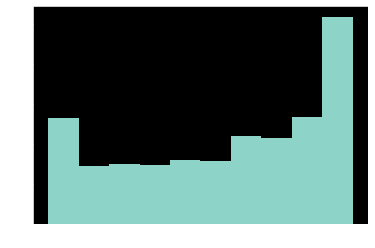

In [108]:
plt.hist(m3_p_values[1])

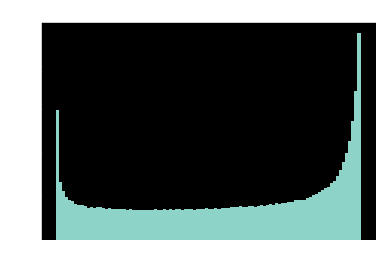

In [109]:
joined_p_values = np.concatenate(np.array(list(m3_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m2.png")
plt.show()

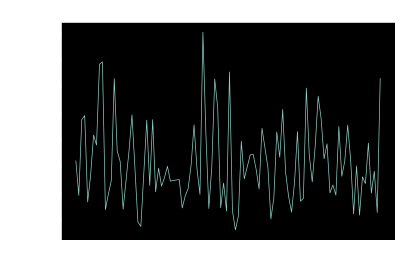

In [110]:
kol_smir_test = {}
for station_id, pvals in m3_p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 3")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m2.png")
plt.show()

In [111]:
ks_df = pd.DataFrame(kol_smir_test.values(), index=kol_smir_test.keys(), columns = ["ks"])
ks_df.head()
outlier_ids = ks_df[ks_df.ks > 0.5].index.to_numpy()
print(outlier_ids)
for id in outlier_ids:
    print(optimal_parameters[id])

[]


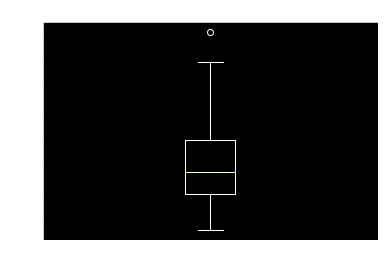

In [112]:
plt.boxplot(kol_smir_test.values())
plt.title("Boxplot of Kolmogorov-Smirnov test statistic for Model 3")
plt.show()

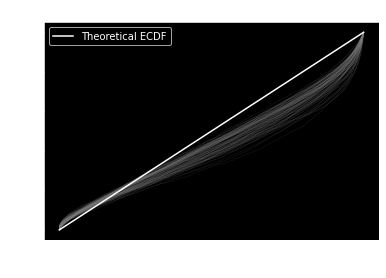

In [114]:
for station, pvals in m3_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()